In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

backend = AerSimulator()

def clean01(s: str) -> str:
    return re.sub(r'[^01]', '', s)

def parse_last_bits(key: str, nbits: int):
    """取 counts key 的末尾 nbits 位（去掉空格/换行等），返回字符串与bit数组。"""
    c = clean01(key)
    tail = c[-nbits:]
    return tail, [int(b) for b in tail]

def draw_graph_nodes_edges(ax, coords, edges, node_style=None, edge_style=None):
    node_style = node_style or {}
    edge_style = edge_style or {"alpha":0.35, "linewidth":2}
    for (u,v) in edges:
        x1,y1 = coords[u]; x2,y2 = coords[v]
        ax.plot([x1,x2],[y1,y2], **edge_style)
    for n,(x,y) in coords.items():
        ax.scatter([x],[y], **(node_style.get(n, {"s":90})))
        ax.text(x+0.04, y+0.04, n, fontsize=10)


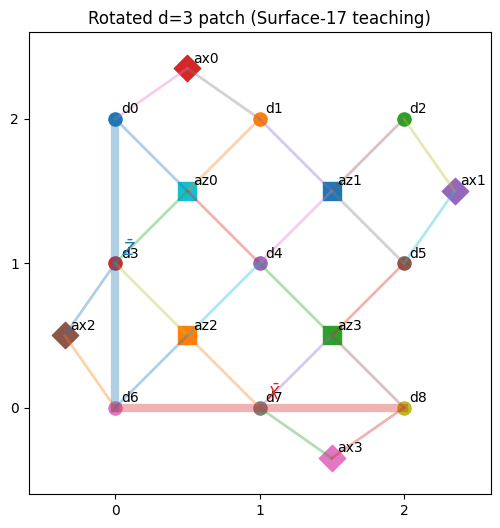

In [2]:
# --- Rotated Surface-17 teaching patch (your current model) ---

DATA17 = [f"d{i}" for i in range(9)]
AZ17   = [f"az{i}" for i in range(4)]
AX17   = [f"ax{i}" for i in range(4)]

# data coordinates (match your plot convention)
DATA17_COORDS = {
    "d0": (0,2), "d1": (1,2), "d2": (2,2),
    "d3": (0,1), "d4": (1,1), "d5": (2,1),
    "d6": (0,0), "d7": (1,0), "d8": (2,0),
}

# Z plaquettes (weight-4)
Z17 = [
    {"name":"Zp0", "anc":"az0", "data":["d0","d1","d3","d4"]},
    {"name":"Zp1", "anc":"az1", "data":["d1","d2","d4","d5"]},
    {"name":"Zp2", "anc":"az2", "data":["d3","d4","d6","d7"]},
    {"name":"Zp3", "anc":"az3", "data":["d4","d5","d7","d8"]},
]

# X boundary checks (weight-2) –– as you requested earlier
X17 = [
    {"name":"Xs0", "anc":"ax0", "data":["d0","d1"]},  # top
    {"name":"Xs1", "anc":"ax1", "data":["d2","d5"]},  # right
    {"name":"Xs2", "anc":"ax2", "data":["d3","d6"]},  # left
    {"name":"Xs3", "anc":"ax3", "data":["d7","d8"]},  # bottom
]

def plot_surface17(show_logicals=False):
    fig, ax = plt.subplots(figsize=(6,6))

    # Z ancilla at plaquette centers
    def center_of(dlist):
        xs = [DATA17_COORDS[d][0] for d in dlist]
        ys = [DATA17_COORDS[d][1] for d in dlist]
        return float(np.mean(xs)), float(np.mean(ys))

    # place X ancilla outside
    ax0 = ((DATA17_COORDS["d0"][0]+DATA17_COORDS["d1"][0])/2, DATA17_COORDS["d0"][1]+0.35)
    ax1 = (DATA17_COORDS["d2"][0]+0.35, (DATA17_COORDS["d2"][1]+DATA17_COORDS["d5"][1])/2)
    ax2 = (DATA17_COORDS["d3"][0]-0.35, (DATA17_COORDS["d3"][1]+DATA17_COORDS["d6"][1])/2)
    ax3 = ((DATA17_COORDS["d7"][0]+DATA17_COORDS["d8"][0])/2, DATA17_COORDS["d7"][1]-0.35)
    AXPOS = {"ax0":ax0, "ax1":ax1, "ax2":ax2, "ax3":ax3}

    # data
    for d,(x,y) in DATA17_COORDS.items():
        ax.scatter([x],[y], s=90)
        ax.text(x+0.04,y+0.04,d,fontsize=10)

    # Z checks (squares)
    for stab in Z17:
        cx,cy = center_of(stab["data"])
        ax.scatter([cx],[cy], marker='s', s=180)
        ax.text(cx+0.04,cy+0.04, stab["anc"], fontsize=10)
        for d in stab["data"]:
            x,y = DATA17_COORDS[d]
            ax.plot([cx,x],[cy,y], linewidth=2, alpha=0.35)

    # X checks (diamonds)
    for stab in X17:
        cx,cy = AXPOS[stab["anc"]]
        ax.scatter([cx],[cy], marker='D', s=180)
        ax.text(cx+0.04,cy+0.04, stab["anc"], fontsize=10)
        for d in stab["data"]:
            x,y = DATA17_COORDS[d]
            ax.plot([cx,x],[cy,y], linewidth=2, alpha=0.35)

    # optional logical operators (see next cell)
    if show_logicals:
        # choose one valid pair (not unique)
        logical_Z = ["d0","d3","d6"]   # vertical string (distance 3)
        logical_X = ["d6","d7","d8"]   # horizontal string (distance 3)

        # draw them as thick colored paths
        def draw_path(qubits, color, label):
            pts = [DATA17_COORDS[q] for q in qubits]
            xs = [p[0] for p in pts]
            ys = [p[1] for p in pts]
            ax.plot(xs, ys, linewidth=6, alpha=0.35, color=color)
            ax.text(xs[len(xs)//2]+0.05, ys[len(ys)//2]+0.05, label, fontsize=12, color=color)

        draw_path(logical_Z, "tab:blue", r"$\bar{Z}$")
        draw_path(logical_X, "tab:red",  r"$\bar{X}$")

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-0.6, 2.6)
    ax.set_ylim(-0.6, 2.6)
    ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
    ax.set_title("Rotated d=3 patch (Surface-17 teaching)")
    plt.show()

plot_surface17(show_logicals=True)


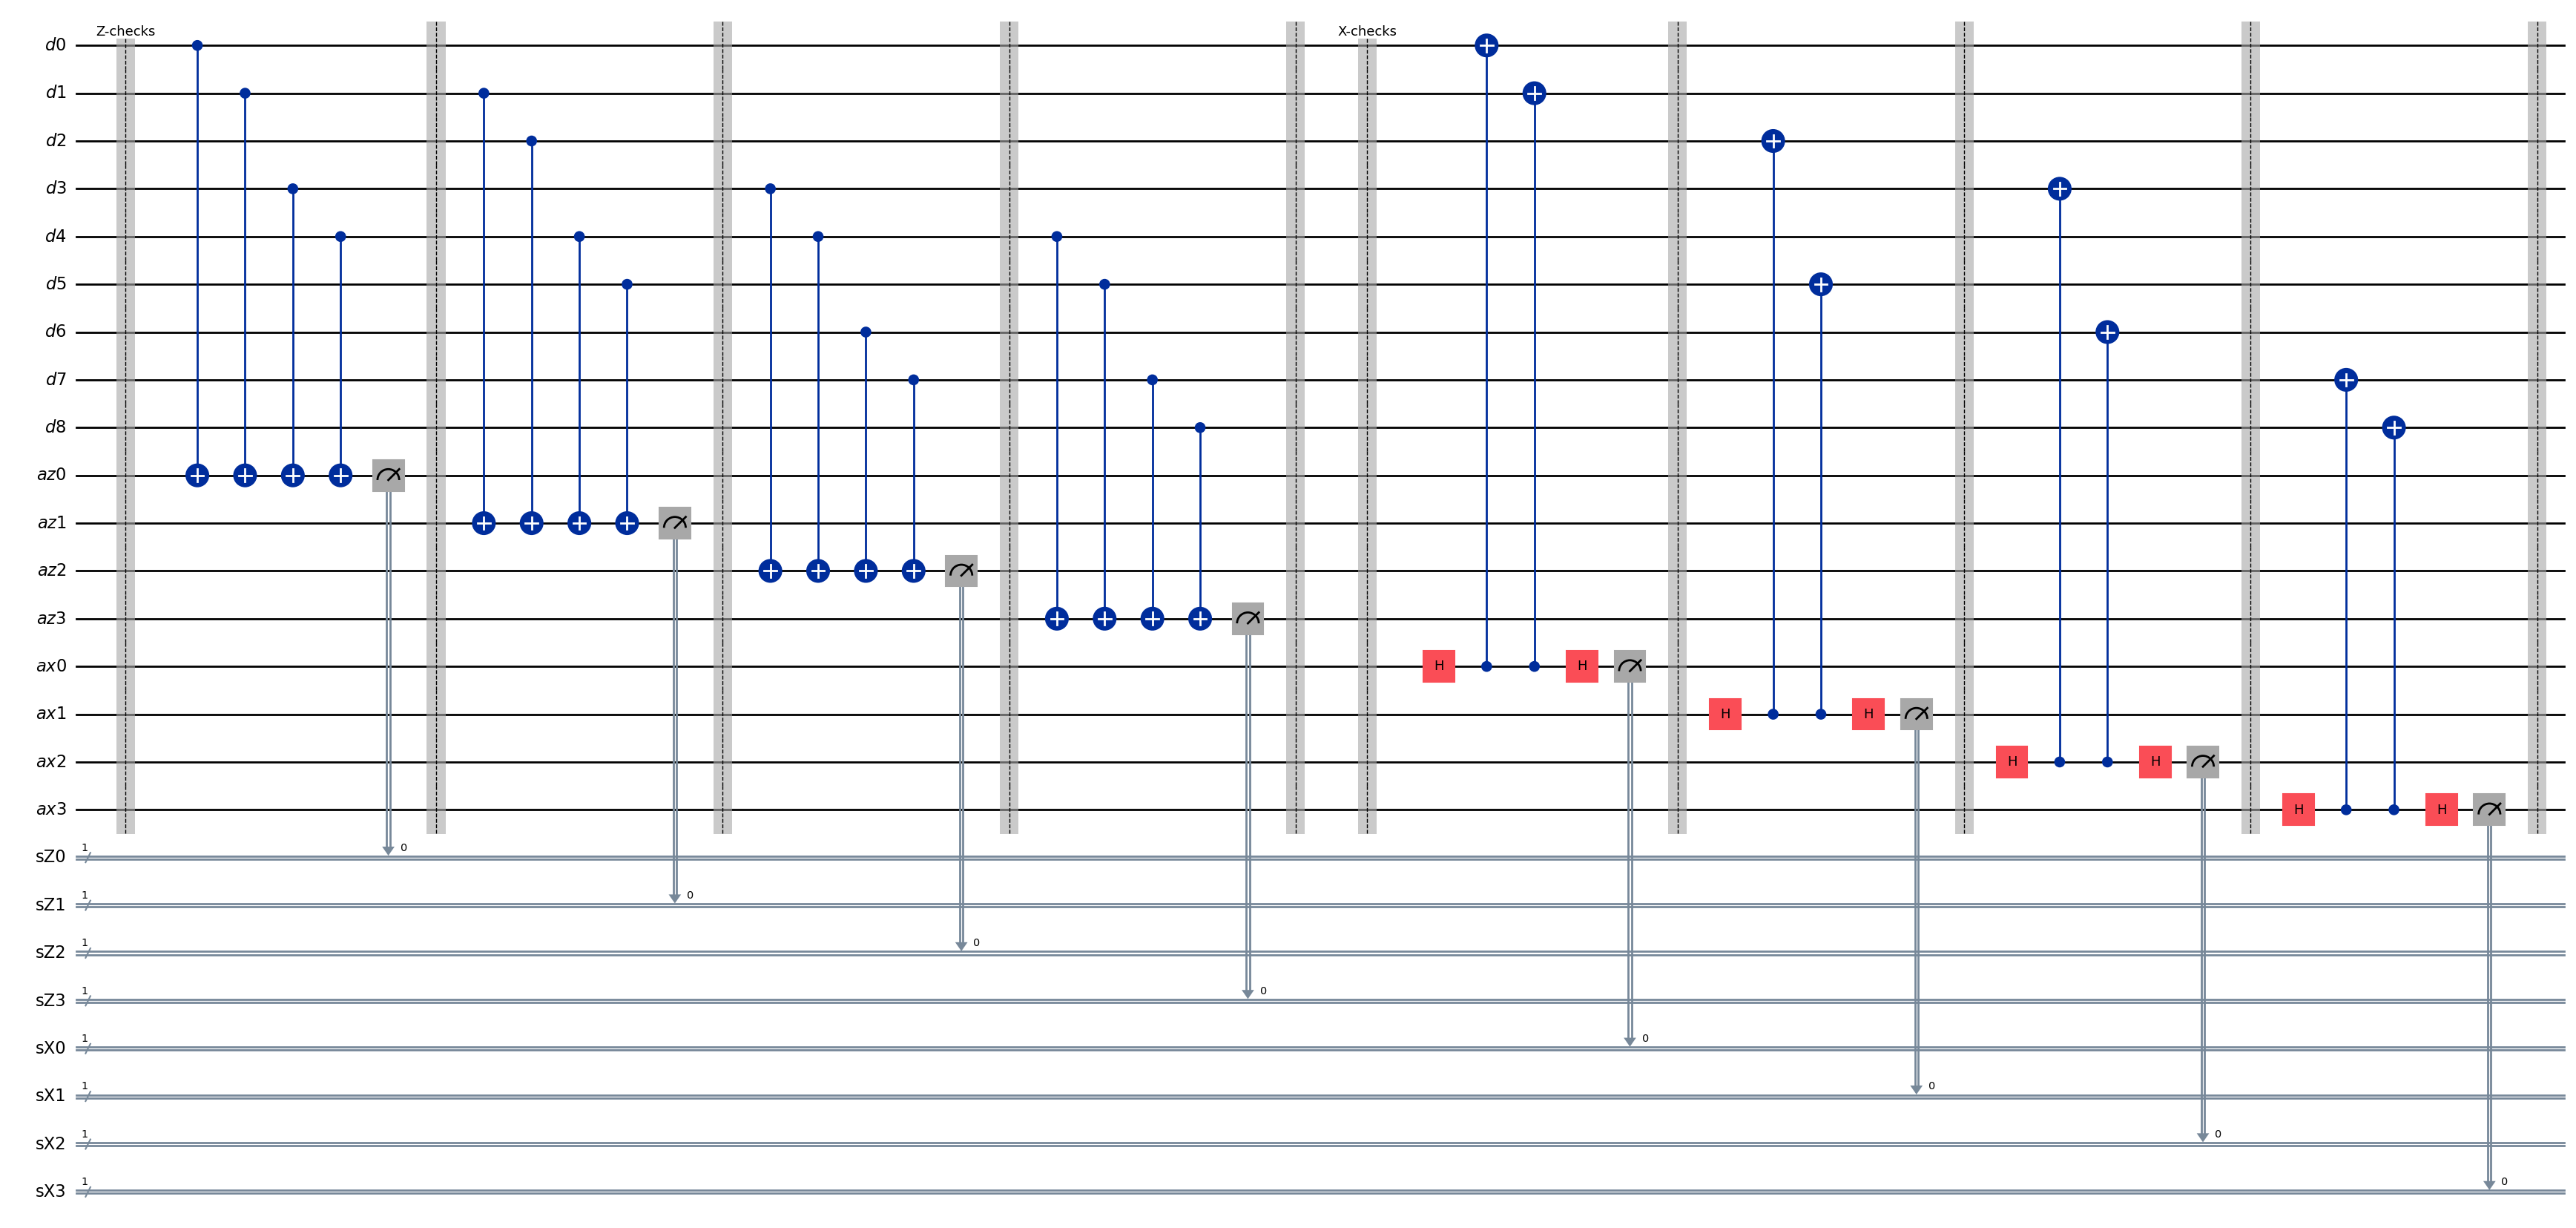

In [3]:
def make_named_qubits17():
    qregs = {}
    for d in DATA17:
        qregs[d] = QuantumRegister(1, d)
    for a in AZ17:
        qregs[a] = QuantumRegister(1, a)
    for a in AX17:
        qregs[a] = QuantumRegister(1, a)
    return qregs

def make_named_cregs17():
    cregs = {}
    for i in range(4):
        cregs[f"sZ{i}"] = ClassicalRegister(1, f"sZ{i}")
    for i in range(4):
        cregs[f"sX{i}"] = ClassicalRegister(1, f"sX{i}")
    return cregs

def Q(qregs, name): return qregs[name][0]
def C(cregs, name): return cregs[name][0]

def measure_Z_check(qc, qregs, anc, data_list, cbit):
    # data -> anc
    for d in data_list:
        qc.cx(Q(qregs,d), Q(qregs,anc))
    qc.measure(Q(qregs,anc), cbit)

def measure_X_check(qc, qregs, anc, data_list, cbit):
    # H(anc) ; anc -> data ; H(anc) ; measure
    qc.h(Q(qregs,anc))
    for d in data_list:
        qc.cx(Q(qregs,anc), Q(qregs,d))
    qc.h(Q(qregs,anc))
    qc.measure(Q(qregs,anc), cbit)

def build_one_round_surface17(measure_both=True):
    qregs = make_named_qubits17()
    cregs = make_named_cregs17()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="Surface17_round")

    qc.barrier(label="Z-checks")
    for i, stab in enumerate(Z17):
        measure_Z_check(qc, qregs, stab["anc"], stab["data"], C(cregs,f"sZ{i}"))
        qc.barrier()

    if measure_both:
        qc.barrier(label="X-checks")
        for i, stab in enumerate(X17):
            measure_X_check(qc, qregs, stab["anc"], stab["data"], C(cregs,f"sX{i}"))
            qc.barrier()
    return qc

qc17 = build_one_round_surface17(measure_both=True)
display(qc17.draw("mpl", fold=-1))


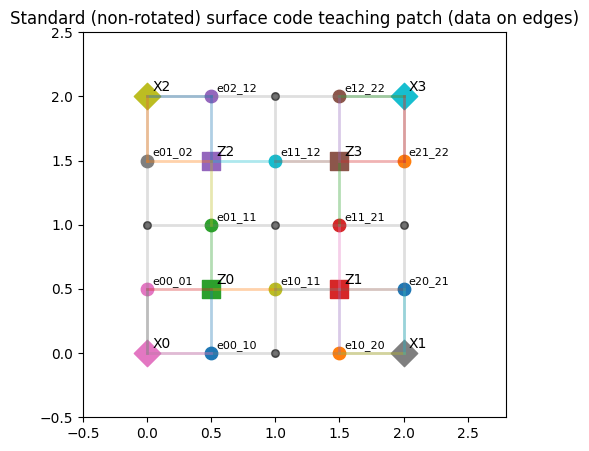

In [4]:
# --- Standard (non-rotated) surface code teaching patch: data on edges ---

# vertices (star centers)
V = [(0,0),(1,0),(2,0),
     (0,1),(1,1),(2,1),
     (0,2),(1,2),(2,2)]
Vn = {f"v{x}{y}":(x,y) for (x,y) in V}

# plaquette centers (faces) in a 2x2 region
P = [(0.5,0.5),(1.5,0.5),(0.5,1.5),(1.5,1.5)]
Pn = {f"p{i}":P[i] for i in range(4)}

# edges (data qubits): horizontal and vertical edges in the 2x2 face region (3x3 vertex grid)
E = []
# horizontal edges between (x,y)-(x+1,y)
for y in [0,1,2]:
    for x in [0,1]:
        E.append(((x,y),(x+1,y)))
# vertical edges between (x,y)-(x,y+1)
for x in [0,1,2]:
    for y in [0,1]:
        E.append(((x,y),(x,y+1)))

# name edges as data qubits
def edge_name(e):
    (x1,y1),(x2,y2)=e
    return f"e{x1}{y1}_{x2}{y2}"

DATA_bulk = [edge_name(e) for e in E]
DATA_bulk_coords = {edge_name(e):((e[0][0]+e[1][0])/2,(e[0][1]+e[1][1])/2) for e in E}

# Z-plaquettes: each face touches 4 surrounding edges
# face at (x+0.5, y+0.5) for x=0,1 and y=0,1
def plaquette_edges(x,y):
    # around square with corners (x,y),(x+1,y),(x,y+1),(x+1,y+1)
    top    = edge_name(((x,y+1),(x+1,y+1)))
    bottom = edge_name(((x,y),(x+1,y)))
    left   = edge_name(((x,y),(x,y+1)))
    right  = edge_name(((x+1,y),(x+1,y+1)))
    return [bottom,right,top,left]

Z_bulk = [
    {"name":"Zp0", "anc":"Z0", "center":(0.5,0.5), "data":plaquette_edges(0,0)},
    {"name":"Zp1", "anc":"Z1", "center":(1.5,0.5), "data":plaquette_edges(1,0)},
    {"name":"Zp2", "anc":"Z2", "center":(0.5,1.5), "data":plaquette_edges(0,1)},
    {"name":"Zp3", "anc":"Z3", "center":(1.5,1.5), "data":plaquette_edges(1,1)},
]

# X-stars: at vertices, touch incident edges (degree 2/3/4 depending boundary)
def incident_edges(x,y):
    inc=[]
    # left edge
    if x-1>=0: inc.append(edge_name(((x-1,y),(x,y))))
    # right edge
    if x+1<=2: inc.append(edge_name(((x,y),(x+1,y))))
    # down edge
    if y-1>=0: inc.append(edge_name(((x,y-1),(x,y))))
    # up edge
    if y+1<=2: inc.append(edge_name(((x,y),(x,y+1))))
    return inc

# choose 4 interior/boundary stars for teaching (corners give weight-2, edges weight-3, center weight-4)
X_bulk = [
    {"name":"Xs0","anc":"X0","center":(0,0),"data":incident_edges(0,0)},   # weight-2
    {"name":"Xs1","anc":"X1","center":(2,0),"data":incident_edges(2,0)},   # weight-2
    {"name":"Xs2","anc":"X2","center":(0,2),"data":incident_edges(0,2)},   # weight-2
    {"name":"Xs3","anc":"X3","center":(2,2),"data":incident_edges(2,2)},   # weight-2
]

def plot_bulk_patch():
    fig, ax = plt.subplots(figsize=(7,5))

    # draw vertex grid
    for name,(x,y) in Vn.items():
        ax.scatter([x],[y], s=30, color="black", alpha=0.6)

    # draw edges (data)
    for e in E:
        (x1,y1),(x2,y2)=e
        ax.plot([x1,x2],[y1,y2], linewidth=2, alpha=0.25, color="gray")

    # draw data qubits
    for d,(x,y) in DATA_bulk_coords.items():
        ax.scatter([x],[y], s=80)
        ax.text(x+0.04,y+0.04,d,fontsize=8)

    # draw Z plaquettes
    for z in Z_bulk:
        cx,cy = z["center"]
        ax.scatter([cx],[cy], marker="s", s=180)
        ax.text(cx+0.04,cy+0.04,z["anc"],fontsize=10)
        for d in z["data"]:
            x,y = DATA_bulk_coords[d]
            ax.plot([cx,x],[cy,y], linewidth=2, alpha=0.35)

    # draw X stars (selected)
    for xst in X_bulk:
        cx,cy = xst["center"]
        ax.scatter([cx],[cy], marker="D", s=180)
        ax.text(cx+0.04,cy+0.04,xst["anc"],fontsize=10)
        for d in xst["data"]:
            x,y = DATA_bulk_coords[d]
            ax.plot([cx,x],[cy,y], linewidth=2, alpha=0.35)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-0.5,2.8); ax.set_ylim(-0.5,2.5)
    ax.set_title("Standard (non-rotated) surface code teaching patch (data on edges)")
    plt.show()

plot_bulk_patch()
